In [10]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from finta import TA

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, accuracy_score

In [7]:
# Defining constants for data mining
num_days = 10000
interval = '1d'
symbol = 'DIS'

INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

RSI: Relative Strength Index - generates overbought and oversold trading signals (above 70 = overbought, below 30 = oversold) by measuring the velocity of price movements. 

MACD: Moving Average Convergence Divergence

STOCH: Stochastic Oscillator %K - generates overbought and oversold trading signals (above 80 = overbought, below 20 = oversold) on the assumption that closing prices move in the same direction as the current trend. 

ADL: Accumulation-Distribution Line

ATR: Average True Range

MOM: Market Momentum

MFI: Money Flow Index

ROC: Rate of Change

OBV: On Balance Volume

CCI: Commodity Channel Index

EMV: Ease of Movement

VORTEX: Vortex Indicator

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

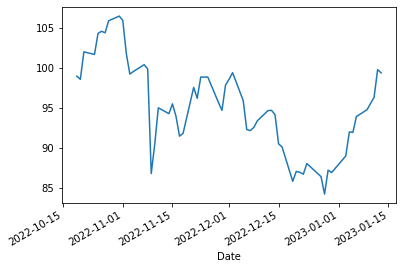

In [22]:
start = (datetime.date.today() - datetime.timedelta(num_days))
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=interval)
data.rename(columns={"Close": 'close', "High":'high', "Low":'low', "Volume":'volume', "Open": 'open'}, inplace=True)
data.head()

tmp = data.iloc[-60:]
tmp['close'].plot()

Exponential Moving Average (EMA): Places more weight on recent price data. It reacts more significantly to recent price changes than a simple moving average (SMA), which applies an equal weight to all observations. This is a "lagging indicator" - it reflects past performance or output that can be seen in operational data or financial statements. 

<AxesSubplot:xlabel='Date'>

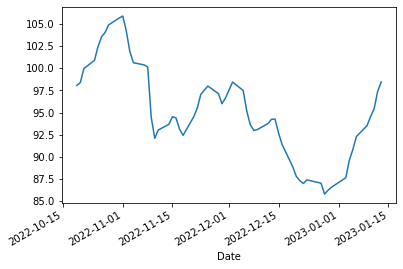

In [29]:
def _exponential_smooth(data, alpha):
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)
tmp1 = data2.iloc[-60:]
tmp1['close'].plot()

In [34]:
def _get_indicator_data(data):
    """ Function that uses the finta API to calculate technical indicators used as the features """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close']/data['close'].ewm(50).mean()
    data['ema21'] = data['close']/data['close'].ewm(21).mean()
    data['ema15'] = data['close']/data['close'].ewm(15).mean()
    data['ema5'] = data['close']/data['close'].ewm(5).mean()

    # Normalize volume value with a moving volume average
    data['normVol'] = data['volume']/data['volume'].ewm(5).mean()

    # Remove columns that won't be used
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)
data
        

,close,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
Date,,,,,,,,,,,,,,,,,,,,
1995-08-31 00:00:00-04:00,18.496876,NaN,0.000000,0.000000,NaN,-1.387972e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1995-09-01 00:00:00-04:00,18.451768,0.000000,-0.001012,-0.000562,NaN,-2.586983e+06,NaN,NaN,NaN,NaN,-2.436974e+06,-66.666667,NaN,NaN,NaN,0.998791,0.998808,0.998819,0.998890,1.023607
1995-09-05 00:00:00-04:00,18.298516,0.000000,-0.006042,-0.002808,NaN,-4.386707e+06,NaN,NaN,NaN,NaN,-5.464087e+06,-100.000000,NaN,NaN,NaN,0.993706,0.993802,0.993867,0.994294,1.148170
1995-09-06 00:00:00-04:00,18.261246,0.000000,-0.009527,-0.005084,NaN,-5.296369e+06,NaN,NaN,NaN,NaN,-8.947869e+06,-90.565355,NaN,NaN,NaN,0.993811,0.993966,0.994070,0.994744,1.197495
1995-09-07 00:00:00-04:00,18.217100,0.000000,-0.012977,-0.007432,NaN,-6.442032e+06,NaN,NaN,NaN,NaN,-1.274687e+07,-86.448008,NaN,NaN,NaN,0.993183,0.993399,0.993543,0.994462,1.203296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09 00:00:00-05:00,93.509615,58.487256,-1.099034,-1.958957,91.355651,2.303788e+09,2.512575,6.548416,55.416899,6.537709,2.270235e+09,83.249952,0.030739,0.958196,1.034622,0.949233,1.005880,1.020239,1.038746,0.830135
2023-01-10 00:00:00-05:00,94.526851,61.390576,-0.656939,-1.698554,94.920966,2.309017e+09,2.438184,7.161432,63.568032,8.304555,2.279823e+09,103.294790,0.068323,0.888065,1.135082,0.960321,1.016045,1.029322,1.041360,0.722573
2023-01-11 00:00:00-05:00,95.413294,63.768579,-0.232368,-1.405316,96.742208,2.314655e+09,2.372819,8.418921,71.566300,9.719387,2.288810e+09,119.708996,0.098289,0.812726,1.209419,0.969910,1.024382,1.036450,1.042245,0.715818


In [35]:
live_pred_data = data.iloc[-18:-13]

In [36]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    """

    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)

    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna()
data.tail()


,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-12-15 00:00:00-05:00,38.103656,-1.218307,-1.108759,13.288138,2.292604e+09,2.873340,-4.880466,38.633689,-3.471114,2.269232e+09,-91.447972,-0.084948,1.109529,0.882938,0.909317,0.953868,0.964025,0.981872,1.069696,1.0
2022-12-16 00:00:00-05:00,34.687479,-1.375209,-1.162049,12.059352,2.288342e+09,2.848627,-7.073659,37.739080,-5.453154,2.249248e+09,-139.128918,-0.098508,1.154791,0.853884,0.898491,0.943148,0.953561,0.973373,1.312754,1.0
2022-12-19 00:00:00-05:00,29.171097,-1.683824,-1.266404,7.032559,2.277817e+09,2.880285,-8.642080,36.727438,-8.911737,2.229007e+09,-198.561335,-0.105098,1.165025,0.822202,0.875842,0.920565,0.931459,0.955004,1.260424,1.0
2022-12-20 00:00:00-05:00,27.170616,-1.992992,-1.411722,7.702307,2.271922e+09,2.841824,-7.409510,36.307682,-10.850674,2.210983e+09,-198.102352,-0.114248,1.204788,0.805133,0.867440,0.913087,0.924702,0.952334,1.099922,1.0
2022-12-21 00:00:00-05:00,26.289191,-2.251803,-1.579738,5.987182,2.267004e+09,2.792338,-6.337678,29.086575,-10.482055,2.196196e+09,-180.423267,-0.129357,1.240337,0.773708,0.864902,0.911776,0.924161,0.955430,0.917296,1.0


Random Forest Classifier Model

In [40]:
def _train_random_forest(X_train, y_train, X_test, y_test):
    """
    Function that uses random forest classifier to train the model 
    """
    # Create a new random forest classifier
    rf = RandomForestClassifier()

    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110, 130, 140, 150, 160, 180, 200]}

    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)

    # Fit model to training data
    rf_gs.fit(X_train, y_train)

    # Save best model
    rf_best = rf_gs.best_estimator_

    # Check best n estimators value
    print(rf_gs.best_params_)

    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best


KNN Classifier Model

In [44]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors':np.arange(1,20)}

    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)

    # Fit model to training data
    knn_gs.fit(X_train, y_train)

    # Save best model
    knn_best = knn_gs.best_estimator_

    # Check best n_neighbors value
    print(knn_gs.best_params_)

    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return knn_best



Voting Classifier

In [42]:
def _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test):

    # Create a dictionary of our models
    estimators = [('knn',knn_model), ('rf',rf_model)]

    # Create our voting classifier, inputting our models 
    ensemble = VotingClassifier(estimators, voting='hard')

    # fit model to training data
    ensemble.fit(X_train, y_train)

    # test our model on the test data
    print(ensemble.score(X_test, y_test))

    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return ensemble

#ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)
    

In [45]:
def cross_validation(data):

    # Split data into equal partitions of size len_train

    num_train = 10 # Increment of how many starting points (len(data) / num_train = number of train-test sets)
    len_train = 40 # Length of each train-test set

    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []

    i = 0
    while True:

        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1

        if len(df) < 40:
            break

        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X)//10, shuffle=False)

        rf_model = _train_random_forest(X_train, y_train, X_test, y_test)
        knn_model = _train_KNN(X_train, y_train, X_test, y_test)
        ensemble_model = _ensemble_model(rf_model, knn_model, X_train, y_train, X_test, y_test)

        rf_prediction = rf_model.predict(X_test)
        knn_prediction = knn_model.predict(X_test)
        ensemble_prediction = ensemble_model.predict(X_test)

        print('rf prediction is ', rf_prediction)
        print('knn prediction is ', knn_prediction)
        print('ensemble prediction is ', ensemble_prediction)
        print('truth values are ', y_test.values)

        rf_accuracy = accuracy_score(y_test.values, rf_prediction)
        knn_accuracy = accuracy_score(y_test.values, knn_prediction)
        ensemble_accuracy = accuracy_score(y_test.values, ensemble_prediction)

        print(rf_accuracy, knn_accuracy, ensemble_accuracy)
        rf_RESULTS.append(rf_accuracy)
        knn_RESULTS.append(knn_accuracy)
        ensemble_RESULTS.append(ensemble_accuracy)

    print('RF Accuracy = ' + str( sum(rf_RESULTS) / len(rf_RESULTS)))
    print('KNN Accuracy = ' + str( sum(knn_RESULTS) / len(knn_RESULTS)))
    print('Ensemble Accuracy = ' + str( sum(ensemble_RESULTS) / len(ensemble_RESULTS)))

cross_validation(data)


{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.42      0.59        12

    accuracy                           0.42        12
   macro avg       0.50      0.21      0.29        12
weighted avg       1.00      0.42      0.59        12

[[0 0]
 [7 5]]


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_neighbors': 15}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67        12

    accuracy                           0.50        12
   macro avg       0.50      0.25      0.33        12
weighted avg       1.00      0.50      0.67        12

[[0 0]
 [6 6]]


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


rf prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.4166666666666667 1.0 0.5
{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
0.5833333333333334
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.58      1.00      0.74         7

    accuracy                           0.58        12
   macro avg       0.29      0.50      0.37        12
weighted avg       0.34      0.58      0.43        12

[[0 5]
 [0 7]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
0.5833333333333334 0.5833333333333334 0.5833333

/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       1.00      0.09      0.17        11
         1.0       0.09      1.00      0.17         1

    accuracy                           0.17        12
   macro avg       0.55      0.55      0.17        12
weighted avg       0.92      0.17      0.17        12

[[ 1 10]
 [ 0  1]]


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
0.08333333333333333
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        11
         1.0       0.08      1.00      0.15         1

    accuracy                           0.08        12
   macro avg       0.04      0.50      0.08        12
weighted avg       0.01      0.08      0.01        12

[[ 0 11]
 [ 0  1]]
rf prediction is  [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0.16666666666666666 0.0833333333333333

/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{'n_estimators': 110}
              precision    recall  f1-score   support

         0.0       0.33      0.20      0.25         5
         1.0       0.56      0.71      0.63         7

    accuracy                           0.50        12
   macro avg       0.44      0.46      0.44        12
weighted avg       0.46      0.50      0.47        12

[[1 4]
 [2 5]]
{'n_neighbors': 16}
              precision    recall  f1-score   support

         0.0       0.40      0.40      0.40         5
         1.0       0.57      0.57      0.57         7

    accuracy                           0.50        12
   macro avg       0.49      0.49      0.49        12
weighted avg       0.50      0.50      0.50        12

[[2 3]
 [3 4]]
0.5
              precision    recall  f1-score   support

         0.0       0.40      0.40      0.40         5
         1.0       0.57      0.57      0.57         7

    accuracy                           0.50        12
   macro avg       0.49      0.49      0.49        1

/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

{'n_neighbors': 15}
              precision    recall  f1-score   support

         0.0       0.44      0.80      0.57         5
         1.0       0.67      0.29      0.40         7

    accuracy                           0.50        12
   macro avg       0.56      0.54      0.49        12
weighted avg       0.57      0.50      0.47        12

[[4 1]
 [5 2]]
0.5
              precision    recall  f1-score   support

         0.0       0.44      0.80      0.57         5
         1.0       0.67      0.29      0.40         7

    accuracy                           0.50        12
   macro avg       0.56      0.54      0.49        12
weighted avg       0.57      0.50      0.47        12

[[4 1]
 [5 2]]
rf prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
ensemble prediction is  [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
0.5833333333333334 0.5 0.5
{'n_estimators': 130}
            

/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_neighbors': 1}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.33      0.50        12

    accuracy                           0.33        12
   macro avg       0.50      0.17      0.25        12
weighted avg       1.00      0.33      0.50        12

[[0 0]
 [8 4]]


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00      12.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0

[[ 0  0]
 [12  0]]
rf prediction is  [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
knn prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
ensemble prediction is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.5 0.3333333333333333 0.0


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Us

{'n_estimators': 180}
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.83      0.91        12

    accuracy                           0.83        12
   macro avg       0.50      0.42      0.45        12
weighted avg       1.00      0.83      0.91        12

[[ 0  0]
 [ 2 10]]


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'n_neighbors': 13}
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        12

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

[[12]]
0.75
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.75      0.86        12

    accuracy                           0.75        12
   macro avg       0.50      0.38      0.43        12
weighted avg       1.00      0.75      0.86        12

[[0 0]
 [3 9]]
rf prediction is  [1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
knn prediction is  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ensemble prediction is  [1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
truth values are  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.8333333333333334 1.0 0.75


/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoyal/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/avantikagoya

KeyboardInterrupt: 